In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_excel(next(iter(uploaded)))

Saving ECOPETROL.xlsx to ECOPETROL.xlsx


In [3]:
df.head()

,Fecha,Precio,Retorno
0,2021-01-04,2242,NaN
1,2021-01-05,2292,0.022302
2,2021-01-06,2308,0.006981
3,2021-01-07,2373,0.028163
4,2021-01-08,2399,0.010957


In [4]:
#CREACIÓN DE VARIABLES
df['ret_log'] = np.log(df['Precio'] / df['Precio'].shift(1))
df['MMS'] = df['Precio'].rolling(window=2).mean()
df['MME'] = df['Precio'].ewm(span=2, adjust=False).mean()
df['vol_r'] = df['ret_log'].rolling(window=2).std()

In [5]:
# Eliminar valores nulos
df_modelo = df.dropna().reset_index(drop=True)
print(df_modelo.head())

       Fecha  Precio   Retorno   ret_log     MMS          MME     vol_r
0 2021-01-06    2308  0.006981  0.006957  2300.0  2297.111111  0.010677
1 2021-01-07    2373  0.028163  0.027774  2340.5  2347.703704  0.014720
2 2021-01-08    2399  0.010957  0.010897  2386.0  2381.901235  0.011934
3 2021-01-12    2459  0.025010  0.024703  2429.0  2433.300412  0.009762
4 2021-01-13    2438 -0.008540 -0.008577  2448.5  2436.433471  0.023532


In [6]:
#EXTRACCIÓN DE VARIABLES
raw_data = df_modelo[['ret_log', 'MMS', 'MME', 'vol_r']].values
target = df_modelo['ret_log'].values

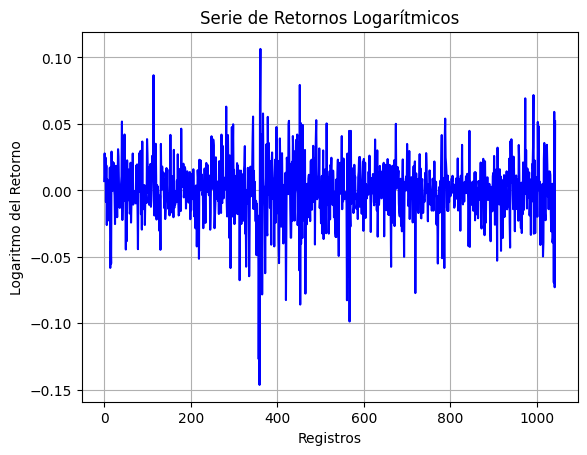

In [7]:
# VISUALIZACIÓN DE LA SERIE
plt.plot(range(len(target)), target, color="blue")
plt.xlabel("Registros")
plt.ylabel("Logaritmo del Retorno")
plt.title("Serie de Retornos Logarítmicos")
plt.grid(True)
plt.show()

In [8]:
#PARTICIÓN DE DATOS 50/25 /25
num_samples = len(raw_data)

# Cálculo de tamaños
num_train_samples = int(0.5 * num_samples)
num_val_samples = int(0.25 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples  # El resto

# Particionar los datos
x_train = raw_data[:num_train_samples]
x_val = raw_data[num_train_samples:num_train_samples + num_val_samples]
x_test = raw_data[num_train_samples + num_val_samples:]

y_train = target[:num_train_samples]
y_val = target[num_train_samples:num_train_samples + num_val_samples]
y_test = target[num_train_samples + num_val_samples:]

print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)


x_train: (521, 4)
x_val: (260, 4)
x_test: (262, 4)
y_train: (521,)
y_val: (260,)
y_test: (262,)


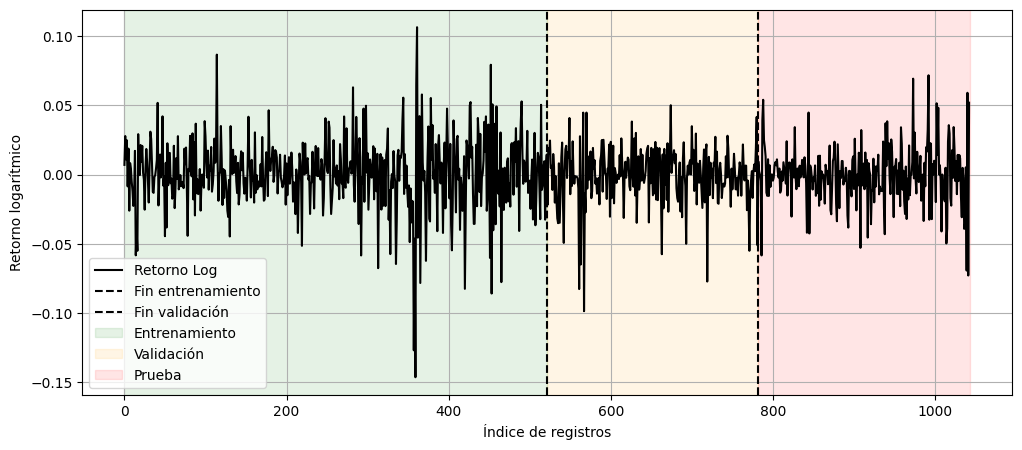

In [9]:
#PARTICIÓN (Train / Val / Test)
num_train_end = num_train_samples
num_val_end = num_train_samples + num_val_samples
num_total = len(target)

plt.figure(figsize=(12, 5))
plt.plot(range(num_total), target, color="black", label="Retorno Log")

# Líneas divisorias
plt.axvline(x=num_train_end, color="black", linestyle="--", label="Fin entrenamiento")
plt.axvline(x=num_val_end, color="black", linestyle="--", label="Fin validación")

# Áreas de colores
plt.axvspan(0, num_train_end, color="green", alpha=0.1, label="Entrenamiento")
plt.axvspan(num_train_end, num_val_end, color="orange", alpha=0.1, label="Validación")
plt.axvspan(num_val_end, num_total, color="red", alpha=0.1, label="Prueba")

plt.grid(True)
plt.xlabel("Índice de registros")
plt.ylabel("Retorno logarítmico")
#plt.title("Separación de conjuntos de datos: Entrenamiento, Validación y Prueba")
plt.legend()
plt.show()


In [10]:
df[['ret_log']].describe()

,ret_log
count,1044.000000
mean,-0.000169
std,0.023165
min,-0.146354
25%,-0.011301
50%,0.000000
75%,0.012524
max,0.106342


In [11]:
#ESCALADO (train, val, test)
from sklearn.preprocessing import MinMaxScaler

# Escalar caracteristicas
scaler_X = MinMaxScaler()
x_train_scaled = scaler_X.fit_transform(x_train)
x_val_scaled = scaler_X.transform(x_val)
x_test_scaled = scaler_X.transform(x_test)

# Escalar variable objetivo
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [12]:
print("x_train:", x_train_scaled)
print("x_val:", x_val_scaled)
print("x_test:", x_test_scaled)

x_train: [[0.60670013 0.19147603 0.18122745 0.07129174]
 [0.68908011 0.21685992 0.21321726 0.09838849]
 [0.6222938  0.24537762 0.23484044 0.07971249]
 ...
 [0.61711285 0.38420558 0.37950179 0.01769099]
 [0.45021625 0.36571608 0.3480189  0.19961113]
 [0.60250874 0.34409276 0.34384762 0.18212029]]
x_val: [[0.63615605 0.36038859 0.35805399 0.04002306]
 [0.49260083 0.35443435 0.33918349 0.17165596]
 [0.65502252 0.35224068 0.35354853 0.19425167]
 ...
 [0.58869505 0.05202131 0.0420124  0.02270424]
 [0.65455072 0.06612347 0.06016392 0.0785979 ]
 [0.74370228 0.10686305 0.10415257 0.10649859]]
x_test: [[ 0.37712883  0.10059542  0.07244662  0.43875717]
 [ 0.61668128  0.0723911   0.07030866  0.28662852]
 [ 0.58849312  0.08022563  0.07170368  0.03348483]
 ...
 [ 0.81264648 -0.08116578 -0.07074307  0.6080913 ]
 [ 0.29065491 -0.08900031 -0.11863542  0.62489606]
 [ 0.78437147 -0.10153557 -0.09455372  0.59103205]]


In [13]:
#PARÁMETROS PARA SERIES TEMPORALES
sampling_rate = 1
sequence_length = 20
delay = 1
batch_size = 32

In [14]:
from tensorflow import keras

#  TRAIN
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=x_train_scaled[:-delay],
    targets=y_train_scaled[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True
)

#  VALIDACIÓN
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=x_val_scaled[:-delay],
    targets=y_val_scaled[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size
)

# TEST
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=x_test_scaled[:-delay],
    targets=y_test_scaled[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size
)


In [15]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)


Inputs shape: (32, 20, 4)
Targets shape: (32, 1)


In [16]:
# Reconstruimos las variables necesarias a partir de df_modelo
from sklearn.preprocessing import MinMaxScaler

# Extraer las columnas numéricas relevantes
X = df_modelo[['ret_log', 'MMS', 'MME', 'vol_r']].values
y = df_modelo['ret_log'].values

# Escalar
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Parámetros del ventaneo
sequence_length = 20
delay = 1

# ventanas
ventana_X = []
ventana_y = []
for i in range(len(X_scaled) - sequence_length - delay + 1):
    ventana_X.append(X_scaled[i:i+sequence_length])
    ventana_y.append(y_scaled[i+sequence_length+delay-1][0])  # target

X_array = np.array(ventana_X)
y_array = np.array(ventana_y)


columnas = ['ret_log', 'MMS', 'MME', 'vol_r']
ventana_df = pd.DataFrame(X_array[0], columns=columnas)
ventana_df['target'] = y_array[0]
print(ventana_df)

     ret_log       MMS       MME     vol_r    target
0   0.606700  0.345178  0.344469  0.071547  0.663472
1   0.689080  0.365736  0.370081  0.098636  0.663472
2   0.622294  0.388832  0.387393  0.079966  0.663472
3   0.676928  0.410660  0.413413  0.065415  0.663472
4   0.545230  0.420558  0.414999  0.157687  0.663472
5   0.653142  0.426904  0.431053  0.129207  0.663472
6   0.475874  0.422335  0.414804  0.212249  0.663472
7   0.611742  0.411168  0.416138  0.162679  0.663472
8   0.595356  0.418782  0.419957  0.019619  0.663472
9   0.558117  0.418020  0.416843  0.044588  0.663472
10  0.531797  0.407360  0.406018  0.031514  0.663472
11  0.489417  0.386294  0.384185  0.050743  0.663472
12  0.528413  0.364975  0.366782  0.046692  0.663472
13  0.646704  0.367513  0.374481  0.141633  0.663472
14  0.348247  0.343655  0.331824  0.357353  0.663472
15  0.425381  0.288071  0.288918  0.092355  0.663472
16  0.361107  0.237310  0.235804  0.076957  0.663472
17  0.694441  0.223350  0.238349  0.399112  0.

In [17]:
ventana_df = pd.DataFrame(X_array[0], columns=columnas)
ventana_df['t'] = range(sequence_length)
ventana_df = ventana_df.set_index('t').T

# Agregamos el target como una nueva fila
ventana_df.loc['target'] = [np.nan]*(sequence_length - 1) + [y_array[0]]

# Mostrar
display(ventana_df)


t,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ret_log,0.606700,0.689080,0.622294,0.676928,0.545230,0.653142,0.475874,0.611742,0.595356,0.558117,0.531797,0.489417,0.528413,0.646704,0.348247,0.425381,0.361107,0.694441,0.581064,0.577278
MMS,0.345178,0.365736,0.388832,0.410660,0.420558,0.426904,0.422335,0.411168,0.418782,0.418020,0.407360,0.386294,0.364975,0.367513,0.343655,0.288071,0.237310,0.223350,0.238832,0.238832
MME,0.344469,0.370081,0.387393,0.413413,0.414999,0.431053,0.414804,0.416138,0.419957,0.416843,0.406018,0.384185,0.366782,0.374481,0.331824,0.288918,0.235804,0.238349,0.239535,0.239593
vol_r,0.071547,0.098636,0.079966,0.065415,0.157687,0.129207,0.212249,0.162679,0.019619,0.044588,0.031514,0.050743,0.046692,0.141633,0.357353,0.092355,0.076957,0.399112,0.135750,0.004533
target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663472


In [18]:
ventana_df = pd.DataFrame(X_array[0], columns=columnas)
ventana_df['step'] = range(sequence_length)

# Convertir a formato largo
ventana_largo = ventana_df.melt(id_vars='step', var_name='variable', value_name='valor')

# Agregar target como fila separada
target_row = pd.DataFrame({
    'step': [sequence_length],
    'variable': ['target'],
    'valor': [y_array[0]]
})

ventana_largo = pd.concat([ventana_largo, target_row], ignore_index=True)

# Mostrar
display(ventana_largo)


,step,variable,valor
0,0,ret_log,0.606700
1,1,ret_log,0.689080
2,2,ret_log,0.622294
3,3,ret_log,0.676928
4,4,ret_log,0.545230
...,...,...,...
76,16,vol_r,0.076957
77,17,vol_r,0.399112
78,18,vol_r,0.135750
79,19,vol_r,0.004533


In [19]:
def ventanas_a_pivot(X_array, y_array, columnas, sequence_length):
    frames = []
    for i in range(len(X_array)):
        df = pd.DataFrame(X_array[i], columns=columnas)
        df['t'] = range(sequence_length)
        wide = df.set_index('t').T
        wide['target'] = y_array[i]
        wide['window_id'] = i                 # identificador de ventana
        frames.append(wide.set_index('window_id', append=True))
    return pd.concat(frames)

pivot_all = ventanas_a_pivot(X_array, y_array, columnas, sequence_length)
display(pivot_all.head())


,t,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
,window_id,,,,,,,,,,,,,,,,,,,,,
ret_log,0,0.606700,0.689080,0.622294,0.676928,0.545230,0.653142,0.475874,0.611742,0.595356,0.558117,...,0.489417,0.528413,0.646704,0.348247,0.425381,0.361107,0.694441,0.581064,0.577278,0.663472
MMS,0,0.345178,0.365736,0.388832,0.410660,0.420558,0.426904,0.422335,0.411168,0.418782,0.418020,...,0.386294,0.364975,0.367513,0.343655,0.288071,0.237310,0.223350,0.238832,0.238832,0.663472
MME,0,0.344469,0.370081,0.387393,0.413413,0.414999,0.431053,0.414804,0.416138,0.419957,0.416843,...,0.384185,0.366782,0.374481,0.331824,0.288918,0.235804,0.238349,0.239535,0.239593,0.663472
vol_r,0,0.071547,0.098636,0.079966,0.065415,0.157687,0.129207,0.212249,0.162679,0.019619,0.044588,...,0.050743,0.046692,0.141633,0.357353,0.092355,0.076957,0.399112,0.135750,0.004533,0.663472
ret_log,1,0.689080,0.622294,0.676928,0.545230,0.653142,0.475874,0.611742,0.595356,0.558117,0.531797,...,0.528413,0.646704,0.348247,0.425381,0.361107,0.694441,0.581064,0.577278,0.663472,0.616069


In [20]:
# construimos la ventana “ancha”
ventana_df = pd.DataFrame(X_array[0], columns=columnas)
ventana_df['t'] = range(sequence_length)
ventana_wide = ventana_df.set_index('t').T        # filas = variables, columnas = 0…19

# añadimos una COLUMNA llamada 'target' con el valor de la ventana
ventana_wide['target'] = y_array[0]
P
display(ventana_wide)


t,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
ret_log,0.606700,0.689080,0.622294,0.676928,0.545230,0.653142,0.475874,0.611742,0.595356,0.558117,...,0.489417,0.528413,0.646704,0.348247,0.425381,0.361107,0.694441,0.581064,0.577278,0.663472
MMS,0.345178,0.365736,0.388832,0.410660,0.420558,0.426904,0.422335,0.411168,0.418782,0.418020,...,0.386294,0.364975,0.367513,0.343655,0.288071,0.237310,0.223350,0.238832,0.238832,0.663472
MME,0.344469,0.370081,0.387393,0.413413,0.414999,0.431053,0.414804,0.416138,0.419957,0.416843,...,0.384185,0.366782,0.374481,0.331824,0.288918,0.235804,0.238349,0.239535,0.239593,0.663472
vol_r,0.071547,0.098636,0.079966,0.065415,0.157687,0.129207,0.212249,0.162679,0.019619,0.044588,...,0.050743,0.046692,0.141633,0.357353,0.092355,0.076957,0.399112,0.135750,0.004533,0.663472


In [21]:
def ventanas_a_tabla_plana(X_array, y_array, columnas):
    n_ventanas, secuencia, n_vars = X_array.shape
    data_rows = []
    for i in range(n_ventanas):
        fila = {}
        for paso in range(secuencia):
            for var_idx, var in enumerate(columnas):
                key = f"{var}_{paso}"
                fila[key] = X_array[i, paso, var_idx]
        fila['target'] = y_array[i]
        data_rows.append(fila)
    return pd.DataFrame(data_rows)

tabla_plana = ventanas_a_tabla_plana(X_array, y_array, columnas)
display(tabla_plana.head())


,ret_log_0,MMS_0,MME_0,vol_r_0,ret_log_1,MMS_1,MME_1,vol_r_1,ret_log_2,MMS_2,...,vol_r_17,ret_log_18,MMS_18,MME_18,vol_r_18,ret_log_19,MMS_19,MME_19,vol_r_19,target
0,0.606700,0.345178,0.344469,0.071547,0.689080,0.365736,0.370081,0.098636,0.622294,0.388832,...,0.399112,0.581064,0.238832,0.239535,0.135750,0.577278,0.238832,0.239593,0.004533,0.663472
1,0.689080,0.365736,0.370081,0.098636,0.622294,0.388832,0.387393,0.079966,0.676928,0.410660,...,0.135750,0.577278,0.238832,0.239593,0.004533,0.663472,0.250000,0.254799,0.103203,0.616069
2,0.622294,0.388832,0.387393,0.079966,0.676928,0.410660,0.413413,0.065415,0.545230,0.420558,...,0.004533,0.663472,0.250000,0.254799,0.103203,0.616069,0.266497,0.266618,0.056757,0.660955
3,0.676928,0.410660,0.413413,0.065415,0.545230,0.420558,0.414999,0.157687,0.653142,0.426904,...,0.103203,0.616069,0.266497,0.266618,0.056757,0.660955,0.282995,0.285744,0.053744,0.584563
4,0.545230,0.420558,0.414999,0.157687,0.653142,0.426904,0.431053,0.129207,0.475874,0.422335,...,0.056757,0.660955,0.282995,0.285744,0.053744,0.584563,0.295178,0.293132,0.091467,0.564774


**VENTANEO PIVOTEADO**

In [22]:
def ventanas_a_tabla_plana(
        X_array, y_array, columnas,
        fechas,                # Serie o array de fechas de df_modelo
        sequence_length=20,
        delay=1
    ):
    """
    Convierte las ventanas 3-D a una tabla 2-D estilo
    ret_log_0 … vol_r_19 + columnas de fecha.
    """
    n_ventanas, _, _ = X_array.shape
    filas = []

    for i in range(n_ventanas):
        fila = {}

        # a) features: ret_log_0 … vol_r_19
        for paso in range(sequence_length):
            for var_idx, var in enumerate(columnas):
                fila[f"{var}_{paso}"] = X_array[i, paso, var_idx]

        # b) target
        fila["target"] = y_array[i]

        # c) fechas
        fila["fecha_inicio"] = fechas[i]
        fila["fecha_target"] = fechas[i + sequence_length + delay - 1]

        filas.append(fila)

    return pd.DataFrame(filas)


fechas = df_modelo.index.to_list()

tabla_plana = ventanas_a_tabla_plana(
    X_array, y_array, columnas,
    fechas=fechas,
    sequence_length=sequence_length,
    delay=delay
)

display(tabla_plana.head())


,ret_log_0,MMS_0,MME_0,vol_r_0,ret_log_1,MMS_1,MME_1,vol_r_1,ret_log_2,MMS_2,...,MMS_18,MME_18,vol_r_18,ret_log_19,MMS_19,MME_19,vol_r_19,target,fecha_inicio,fecha_target
0,0.606700,0.345178,0.344469,0.071547,0.689080,0.365736,0.370081,0.098636,0.622294,0.388832,...,0.238832,0.239535,0.135750,0.577278,0.238832,0.239593,0.004533,0.663472,0,20
1,0.689080,0.365736,0.370081,0.098636,0.622294,0.388832,0.387393,0.079966,0.676928,0.410660,...,0.238832,0.239593,0.004533,0.663472,0.250000,0.254799,0.103203,0.616069,1,21
2,0.622294,0.388832,0.387393,0.079966,0.676928,0.410660,0.413413,0.065415,0.545230,0.420558,...,0.250000,0.254799,0.103203,0.616069,0.266497,0.266618,0.056757,0.660955,2,22
3,0.676928,0.410660,0.413413,0.065415,0.545230,0.420558,0.414999,0.157687,0.653142,0.426904,...,0.266497,0.266618,0.056757,0.660955,0.282995,0.285744,0.053744,0.584563,3,23
4,0.545230,0.420558,0.414999,0.157687,0.653142,0.426904,0.431053,0.129207,0.475874,0.422335,...,0.282995,0.285744,0.053744,0.584563,0.295178,0.293132,0.091467,0.564774,4,24


**VENTANEO PIVOTEADO CON EXPORTACIÓN A EXCEL**

In [26]:
# Función para convertir X_array, y_array y fechas a tabla plana
def ventanas_a_tabla_plana(
        X_array, y_array, columnas,
        fechas,
        sequence_length=20,
        delay=1
    ):
    """
    Convierte las ventanas 3D a una tabla 2D con columnas ret_log_0, MMS_0, ..., vol_r_19 + target + fechas.
    """
    n_ventanas, _, _ = X_array.shape
    filas = []

    for i in range(n_ventanas):
        fila = {}

        # a) Features aplanadas
        for paso in range(sequence_length):
            for var_idx, var in enumerate(columnas):
                fila[f"{var}_{paso}"] = X_array[i, paso, var_idx]

        # b) Target
        fila["target"] = y_array[i]

        # c) Fechas
        fila["fecha_inicio"] = fechas[i]
        fila["fecha_target"] = fechas[i + sequence_length + delay - 1]

        filas.append(fila)

    return pd.DataFrame(filas)

# ⇢ Crear tabla plana con fechas
fechas = df_modelo.index.to_list()

tabla_plana = ventanas_a_tabla_plana(
    X_array, y_array, columnas,
    fechas=fechas,
    sequence_length=sequence_length,
    delay=delay
)

# ⇢ Exportar a Excel y descargar (Colab)
import os
from google.colab import files

# Crear carpeta si no existe
out_dir = r"C:\Users\paolo.delahoz\Desktop\Tabla_Pivoteada"
os.makedirs(out_dir, exist_ok=True)

# Guardar archivo
out_path = os.path.join(out_dir, "ventanas_tabla_plana.xlsx")
tabla_plana.to_excel(out_path, index=False)
print(f" Archivo guardado en: {out_path}")

# Descargar automáticamente en Colab
files.download(out_path)


✅ Archivo guardado en: C:\Users\paolo.delahoz\Desktop\Tabla_Pivoteada/ventanas_tabla_plana.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DESCARGAR EXCEL CON VENTANEO GENJIS

In [ ]:
import pandas as pd
import numpy as np

ventanas_list = []
columnas = ['ret_log', 'MMS', 'MME', 'vol_r']

for i in range(X_array.shape[0]):
    df_ventana = pd.DataFrame(X_array[i], columns=columnas)
    df_ventana['target'] = y_array[i]
    df_ventana['ventana_id'] = i  # identificador para cada ventana
    ventanas_list.append(df_ventana)

# Concatenamos todas las ventanas en un solo DataFrame
df_ventanas_completo = pd.concat(ventanas_list, ignore_index=True)

# Guardamos en un archivo Excel
df_ventanas_completo.to_excel("ventanas_series_temporales.xlsx", index=False)


In [ ]:
# === 12. FUNCIÓN DE EVALUACIÓN NAIVE ===
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        # Último valor de la secuencia como predicción naive (primer feature)
        preds = samples[:, -1, 0]

        # Convertir tensores a NumPy
        preds = preds.numpy().reshape(-1, 1)
        targets = targets.numpy()

        # Desescalar predicciones y objetivos
        preds = scaler_y.inverse_transform(preds).flatten()
        targets = scaler_y.inverse_transform(targets).flatten()

        # Calcular error absoluto total
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


In [ ]:
print(f"Validación MAE (naive): {evaluate_naive_method(val_dataset):.4f}")
print(f"Prueba MAE (naive): {evaluate_naive_method(test_dataset):.4f}")


Validación MAE (naive): 0.0214
Prueba MAE (naive): 0.0223


 Si tus modelos (LSTM, CNN, Transformer, etc.) obtienen un MAE menor que 0.0214–0.0223, entonces aprendieron patrones reales en los dato. Si los modelos tienen un MAE similar o mayor, entonces no están mejorando respecto a una estrategia simple y habría que revisar su arquitectura, hiperparámetros o datos.

MODELO: Con dos capas LSTM con 64 unidades.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# === 1. DEFINICIÓN DEL MODELO ===
model = Sequential([ LSTM(64, input_shape=(sequence_length, x_train_scaled.shape[1])), Dense(2)])
# === 2. COMPILACIÓN ===
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# === 3. ENTRENAMIENTO ===
history = model.fit( train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1796 - mae: 0.3787 - val_loss: 0.0098 - val_mae: 0.0726
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0221 - mae: 0.1158 - val_loss: 0.0137 - val_mae: 0.0970
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0129 - mae: 0.0848 - val_loss: 0.0071 - val_mae: 0.0630
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0109 - mae: 0.0755 - val_loss: 0.0068 - val_mae: 0.0610
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0111 - mae: 0.0744 - val_loss: 0.0072 - val_mae: 0.0642
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0102 - mae: 0.0753 - val_loss: 0.0074 - val_mae: 0.0663
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0100 - mae: 0.0758 - val_loss: 0.0069 - val_mae: 0.0620
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0098 - mae: 0.0723 - val_loss: 0.0067 - val_mae: 0.0604
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0125 - mae: 0.

In [ ]:
# === 4. EVALUACIÓN ===
loss, mae = model.evaluate(test_dataset)
print(f"Evaluación en test - MAE (modelo LSTM): {mae:.4f}")
# === 5. COMPARACIÓN CON EL MÉTODO NAIVE ===
print(f"Evaluación en test - MAE (naive): {evaluate_naive_method(test_dataset):.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.0746
Evaluación en test - MAE (modelo LSTM): 0.0828
Evaluación en test - MAE (naive): 0.0223


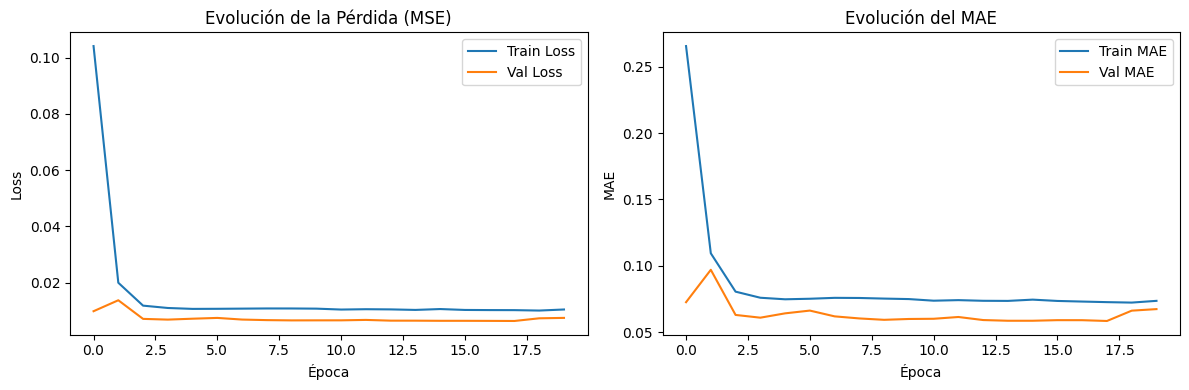

In [ ]:
import matplotlib.pyplot as plt

# === 6. GRÁFICAS DE ENTRENAMIENTO ===
# Extraer historial
hist = history.history
# --- Gráfico de la pérdida (MSE) ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Evolución de la Pérdida (MSE)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# --- Gráfico del MAE ---
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('Evolución del MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


MODELO: DENSE

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# === 1. DEFINICIÓN DEL MODELO FUNCIONAL ===
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  # (20, 4)
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)  # (80,)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
dense_model = keras.Model(inputs, outputs)
# === 2. COMPILACIÓN ===
dense_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# === 3. ENTRENAMIENTO ===
dense_history = dense_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)
# === 4. EVALUACIÓN FINAL ===
loss, mae = dense_model.evaluate(test_dataset)
print(f"Evaluación en test - MAE (Dense): {mae:.4f}")
# === 5. COMPARACIÓN CON EL MÉTODO NAIVE ===
print(f"Evaluación en test - MAE (naive): {evaluate_naive_method(test_dataset):.4f}")


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0434 - mae: 0.1638 - val_loss: 0.0097 - val_mae: 0.0763
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - mae: 0.0970 - val_loss: 0.0088 - val_mae: 0.0737
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - mae: 0.0794 - val_loss: 0.0072 - val_mae: 0.0652
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - mae: 0.0773 - val_loss: 0.0064 - val_mae: 0.0611
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094 - mae: 0.0726 - val_loss: 0.0059 - val_mae: 0.0589
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0646 - val_loss: 0.0056 - val_mae: 0.0574
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0078 - mae: 0.0665 - val_loss: 0.0054 - val_mae: 0.0556
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0614 - val_loss: 0.0048 - val_mae: 0.0528
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062

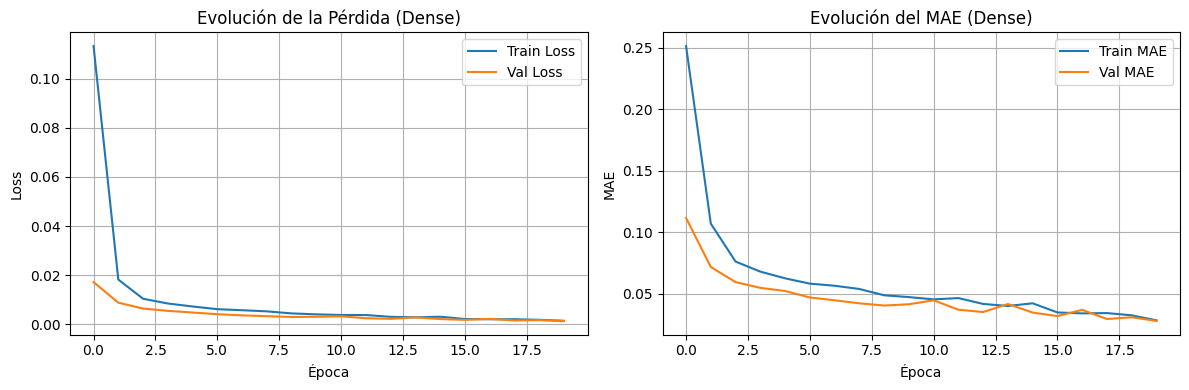

In [ ]:
# === 6. GRÁFICAS DE ENTRENAMIENTO ===
hist = dense_history.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Evolución de la Pérdida (Dense)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('Evolución del MAE (Dense)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


MODELO CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# === 1. DEFINICIÓN DEL MODELO CNN ===
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  # (30, 4) o (20, 4) si sequence_length=20
x = layers.Conv1D(8, kernel_size=5, activation="relu")(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(8, kernel_size=2, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)  # Aplana los filtros en promedio
outputs = layers.Dense(1)(x)

cnn_model = keras.Model(inputs, outputs)

# === 2. COMPILACIÓN ===
cnn_model.compile( optimizer="rmsprop", loss="mse", metrics=["mae"])
# === 3. CALLBACKS (guardar el mejor modelo CNN) ===
callbacks = [keras.callbacks.ModelCheckpoint("mejor_cnn.keras", save_best_only=True)]

# === 4. ENTRENAMIENTO ===
history_cnn = cnn_model.fit( train_dataset, validation_data=val_dataset, epochs=10, callbacks=callbacks)
# === 5. CARGAR EL MEJOR MODELO GUARDADO ===
mejor_cnn = keras.models.load_model("mejor_cnn.keras")
# === 6. EVALUACIÓN ===
mae_test = mejor_cnn.evaluate(test_dataset, verbose=0)[1]
mae_val = mejor_cnn.evaluate(val_dataset, verbose=0)[1]
print(f"Test MAE (CNN): {mae_test:.4f}")
print(f"Validación MAE (CNN): {mae_val:.4f}")


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2499 - mae: 0.4700 - val_loss: 0.1459 - val_mae: 0.3680
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0638 - mae: 0.2086 - val_loss: 0.0263 - val_mae: 0.1380
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0298 - mae: 0.1308 - val_loss: 0.0115 - val_mae: 0.0876
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - mae: 0.0907 - val_loss: 0.0086 - val_mae: 0.0740
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - mae: 0.0795 - val_loss: 0.0073 - val_mae: 0.0631
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - mae: 0.0783 - val_loss: 0.0101 - val_mae: 0.0826
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0119 - mae: 0.0796 - val_loss: 0.0069 - val_mae: 0.0634
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - mae: 0.0769 - val_loss: 0.0070 - val_mae: 0.0648
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0104 

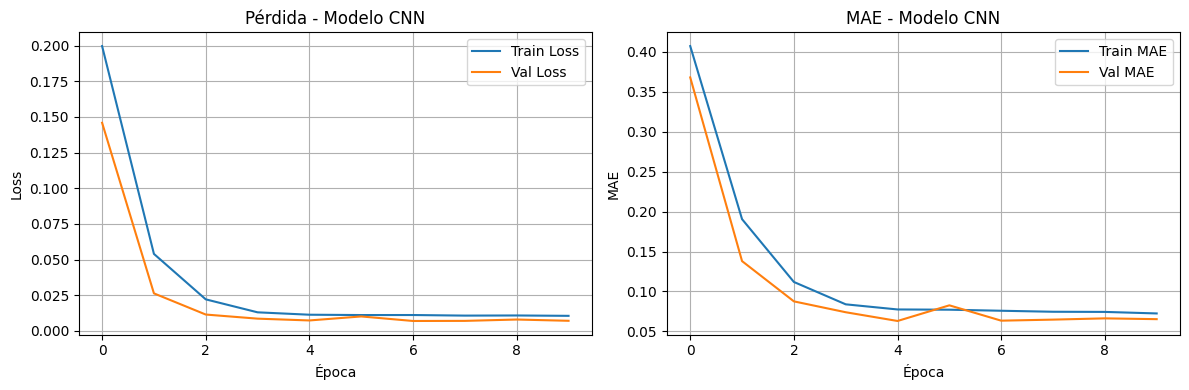

In [ ]:
import matplotlib.pyplot as plt

hist = history_cnn.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Pérdida - Modelo CNN')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('MAE - Modelo CNN')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


MODELO GRU APILADO + DROPOUT PARA SERIES TEMPORALES


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# === 1. DEFINICIÓN DEL MODELO GRU APILADO ===
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  # Ej. (20, 4)
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

gru_model = keras.Model(inputs, outputs)

# === 2. COMPILACIÓN ===
gru_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# === 3. CALLBACKS (guardar el mejor modelo GRU) ===
callbacks = [ keras.callbacks.ModelCheckpoint("mejor_gru.keras", save_best_only=True)]

# === 4. ENTRENAMIENTO ===
history_gru = gru_model.fit( train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

# === 5. CARGAR EL MEJOR MODELO ===
mejor_gru = keras.models.load_model("mejor_gru.keras")

# === 6. EVALUACIÓN ===
mae_test = mejor_gru.evaluate(test_dataset, verbose=0)[1]
mae_val = mejor_gru.evaluate(val_dataset, verbose=0)[1]

print(f"Test MAE (GRU): {mae_test:.4f}")
print(f"Validación MAE (GRU): {mae_val:.4f}")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.1609 - mae: 0.3223 - val_loss: 0.0133 - val_mae: 0.0992
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0422 - mae: 0.1640 - val_loss: 0.0093 - val_mae: 0.0783
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0395 - mae: 0.1509 - val_loss: 0.0173 - val_mae: 0.1163
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0335 - mae: 0.1409 - val_loss: 0.0066 - val_mae: 0.0607
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0275 - mae: 0.1333 - val_loss: 0.0142 - val_mae: 0.1026
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0348 - mae: 0.1475 - val_loss: 0.0071 - val_mae: 0.0646
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0227 - mae: 0.1204 - val_loss: 0.0122 - val_mae: 0.0929
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0225 - mae: 0.1160 - val_loss: 0.0098 - val_mae: 0.0811
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.024

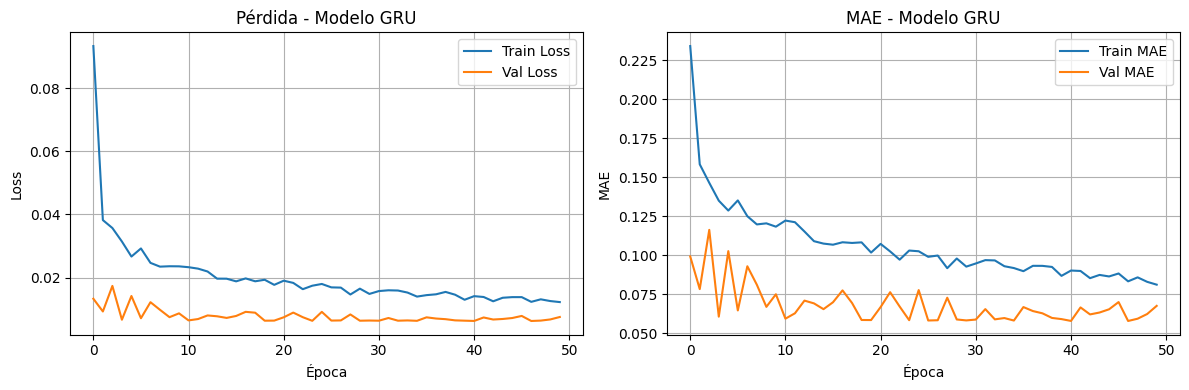

In [ ]:
import matplotlib.pyplot as plt

hist = history_gru.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Pérdida - Modelo GRU')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('MAE - Modelo GRU')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


MODELO BIDIRECCIONAL LSTM

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# === 1. Definición del modelo ===
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  # Ej. (20, 4)

x = layers.Bidirectional(layers.LSTM(16))(inputs)  # LSTM de 16 unidades en ambas direcciones
outputs = layers.Dense(1)(x)  # Salida regresiva (predicción del retorno logarítmico)

model = keras.Model(inputs, outputs)

# === 2. Compilación ===
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

# === 3. Entrenamiento ===
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)

# === 4. Evaluación ===
mae_test = model.evaluate(test_dataset, verbose=0)[1]
mae_val = model.evaluate(val_dataset, verbose=0)[1]

print(f"Test MAE (Bidirectional LSTM): {mae_test:.4f}")
print(f"Validación MAE (Bidirectional LSTM): {mae_val:.4f}")


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1733 - mae: 0.3703 - val_loss: 0.0113 - val_mae: 0.0889
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0130 - mae: 0.0850 - val_loss: 0.0073 - val_mae: 0.0654
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0115 - mae: 0.0807 - val_loss: 0.0067 - val_mae: 0.0611
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0114 - mae: 0.0795 - val_loss: 0.0073 - val_mae: 0.0664
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0126 - mae: 0.0818 - val_loss: 0.0063 - val_mae: 0.0589
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0113 - mae: 0.0770 - val_loss: 0.0079 - val_mae: 0.0707
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0115 - mae: 0.0786 - val_loss: 0.0062 - val_mae: 0.0582
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0101 - mae: 0.0731 - val_loss: 0.0071 - val_mae: 0.0607
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.009

Este modelo es muy bueno cuando cada punto en la secuencia tiene influencia del pasado y del futuro dentro de la misma ventana. En retornos logarítmicos financieros, esto puede funcionar mejor que unidireccionales, especialmente si la dinámica de mercado no es estrictamente causal.



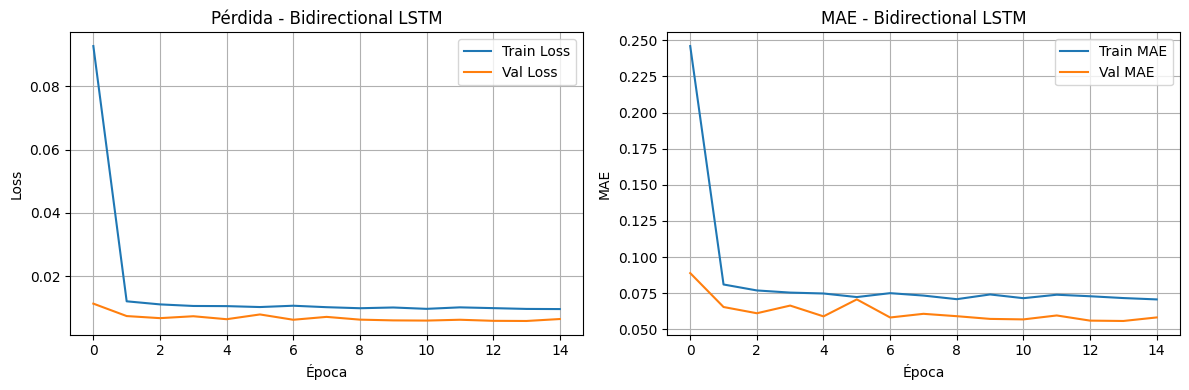

In [ ]:
import matplotlib.pyplot as plt

hist = history.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Pérdida - Bidirectional LSTM')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('MAE - Bidirectional LSTM')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1045 - mae: 0.2246 - val_loss: 0.0148 - val_mae: 0.1059
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0142 - mae: 0.0893 - val_loss: 0.0095 - val_mae: 0.0797
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0131 - mae: 0.0890 - val_loss: 0.0118 - val_mae: 0.0922
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - mae: 0.0871 - val_loss: 0.0150 - val_mae: 0.1067
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0139 - mae: 0.0872 - val_loss: 0.0273 - val_mae: 0.1462
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0181 - mae: 0.1074 - val_loss: 0.0123 - val_mae: 0.0940
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0152 - mae: 0.0933 - val_loss: 0.0063 - val_mae: 0.0581
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0106 - mae: 0.0774 - val_loss: 0.0065 - val_mae: 0.0606
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0142 - mae: 0.

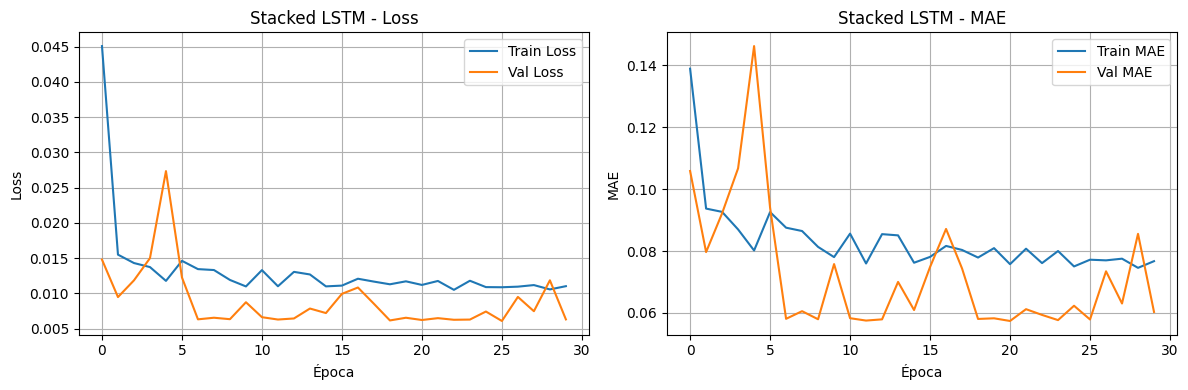

In [ ]:
# === 1. STACKED LSTM ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

stacked_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, raw_data.shape[-1])),
    LSTM(64),
    Dense(1)
])
stacked_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# === ENTRENAMIENTO ===
history_stacked = stacked_lstm.fit(
    train_dataset,
    epochs=30,  # Puedes ajustar este valor
    validation_data=val_dataset
)

# === EVALUACIÓN ===
val_mae = stacked_lstm.evaluate(val_dataset)[1]
test_mae = stacked_lstm.evaluate(test_dataset)[1]
print(f"Validación MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
import matplotlib.pyplot as plt

hist = history_stacked.history

plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Stacked LSTM - Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('Stacked LSTM - MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0528 - mae: 0.1718 - val_loss: 0.0085 - val_mae: 0.0728
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0133 - mae: 0.0902 - val_loss: 0.0089 - val_mae: 0.0679
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0140 - mae: 0.0903 - val_loss: 0.0074 - val_mae: 0.0614
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147 - mae: 0.0909 - val_loss: 0.0078 - val_mae: 0.0687
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - mae: 0.0852 - val_loss: 0.0092 - val_mae: 0.0780
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0131 - mae: 0.0844 - val_loss: 0.0080 - val_mae: 0.0707
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0123 - mae: 0.0801 - val_loss: 0.0079 - val_mae: 0.0703
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107 - mae: 0.0761 - val_loss: 0.0075 - val_mae: 0.0672
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0116 - mae: 0.

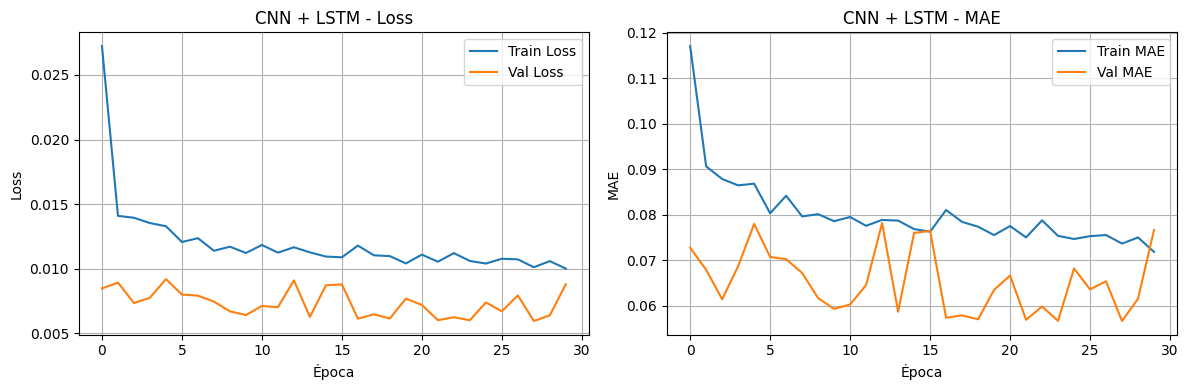

In [ ]:
# === 2. CNN + LSTM ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

cnn_lstm = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(sequence_length, raw_data.shape[-1])),
    MaxPooling1D(2),
    LSTM(64),
    Dense(1)
])
cnn_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Entrenamiento
history_cnn_lstm = cnn_lstm.fit(
    train_dataset,
    epochs=30,  # Puedes ajustar este número
    validation_data=val_dataset
)

# Evaluación
val_mae = cnn_lstm.evaluate(val_dataset)[1]
test_mae = cnn_lstm.evaluate(test_dataset)[1]
print(f"Validación MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

import matplotlib.pyplot as plt

hist = history_cnn_lstm.history

plt.figure(figsize=(12, 4))

# Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('CNN + LSTM - Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Error Absoluto Medio (MAE)
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('CNN + LSTM - MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 75.1879 - mae: 4.0349 - val_loss: 0.0629 - val_mae: 0.1800
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5099 - mae: 0.5285 - val_loss: 0.0481 - val_mae: 0.1585
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.0455 - mae: 0.7387 - val_loss: 0.0461 - val_mae: 0.1750
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5831 - mae: 0.5659 - val_loss: 0.1251 - val_mae: 0.3292
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5207 - mae: 0.6186 - val_loss: 0.0847 - val_mae: 0.2727
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4855 - mae: 0.5597 - val_loss: 0.0129 - val_mae: 0.0778
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1506 - mae: 0.3211 - val_loss: 0.1917 - val_mae: 0.4251
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1383 - mae: 0.2854 - val_loss: 0.2233 - val_mae: 0.4642
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3

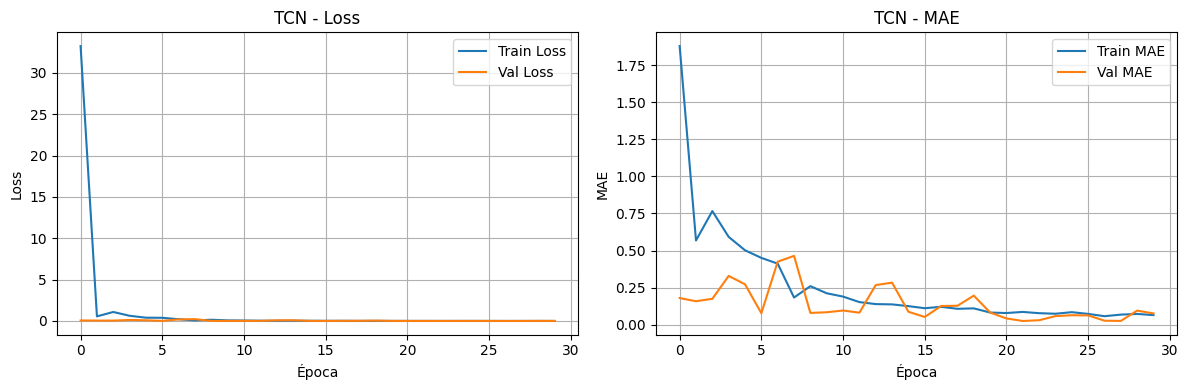

In [ ]:
# === 3. TEMPORAL CONVOLUTIONAL NETWORK (TCN) ===
#!pip install keras-tcn
from tcn import TCN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

inputs = Input(shape=(sequence_length, raw_data.shape[-1]))
x = TCN()(inputs)
outputs = Dense(1)(x)
tcn_model = Model(inputs, outputs)
tcn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Entrenamiento
history_tcn = tcn_model.fit(
    train_dataset,
    epochs=30,  # Puedes ajustar este valor
    validation_data=val_dataset
)

# Evaluación
val_mae = tcn_model.evaluate(val_dataset)[1]
test_mae = tcn_model.evaluate(test_dataset)[1]
print(f"Validación MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

import matplotlib.pyplot as plt

hist = history_tcn.history

plt.figure(figsize=(12, 4))

# Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('TCN - Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('TCN - MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.1536 - mae: 1.0442 - val_loss: 0.2434 - val_mae: 0.4841
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2045 - mae: 0.4218 - val_loss: 0.0174 - val_mae: 0.1130
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0279 - mae: 0.1374 - val_loss: 0.0064 - val_mae: 0.0585
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0120 - mae: 0.0804 - val_loss: 0.0066 - val_mae: 0.0592
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0105 - mae: 0.0739 - val_loss: 0.0063 - val_mae: 0.0582
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - mae: 0.0711 - val_loss: 0.0070 - val_mae: 0.0612
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0108 - mae: 0.0750 - val_loss: 0.0065 - val_mae: 0.0604
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - mae: 0.0733 - val_loss: 0.0062 - val_mae: 0.0575
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.011

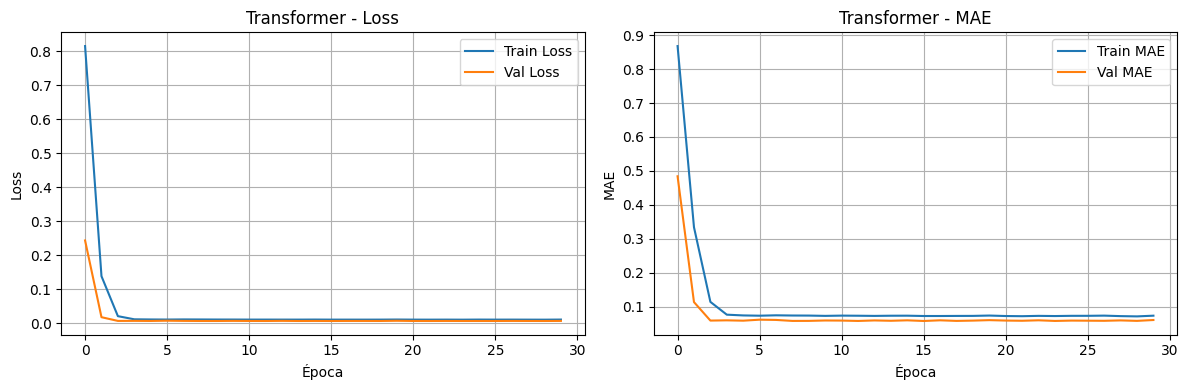

In [ ]:
# === 4. TRANSFORMER BÁSICO ===
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(sequence_length, raw_data.shape[-1]))
x = MultiHeadAttention(num_heads=2, key_dim=4)(inputs, inputs)
x = LayerNormalization()(x)
x = GlobalAveragePooling1D()(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Entrenamiento
history_transformer = transformer_model.fit(
    train_dataset,
    epochs=30,  # Puedes ajustar según rendimiento
    validation_data=val_dataset
)

# Evaluación
val_mae = transformer_model.evaluate(val_dataset)[1]
test_mae = transformer_model.evaluate(test_dataset)[1]
print(f"Validación MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


import matplotlib.pyplot as plt

hist = history_transformer.history

plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Transformer - Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('Transformer - MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.2777 - mae: 0.4194 - val_loss: 0.0075 - val_mae: 0.0680
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0142 - mae: 0.0848 - val_loss: 0.0070 - val_mae: 0.0645
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0134 - mae: 0.0863 - val_loss: 0.0073 - val_mae: 0.0662
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0133 - mae: 0.0835 - val_loss: 0.0066 - val_mae: 0.0584
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0147 - mae: 0.0938 - val_loss: 0.0093 - val_mae: 0.0786
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0143 - mae: 0.0875 - val_loss: 0.0122 - val_mae: 0.0865
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0182 - mae: 0.1012 - val_loss: 0.0142 - val_mae: 0.1034
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0134 - mae: 0.0875 - val_loss: 0.0066 - val_mae: 0.0584
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.014

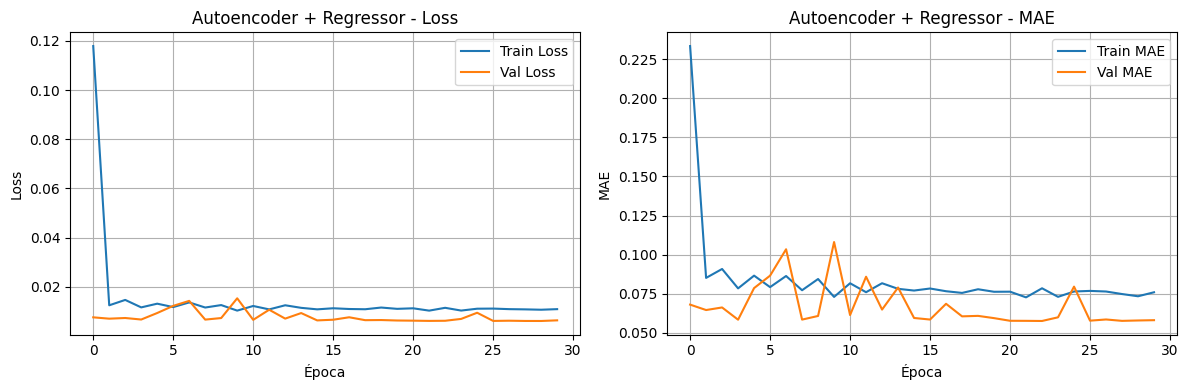

In [ ]:
# === 5. AUTOENCODER + REGRESOR ===
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

auto_input = Input(shape=(sequence_length, raw_data.shape[-1]))
encoded = LSTM(64)(auto_input)
decoded = RepeatVector(sequence_length)(encoded)
decoded = LSTM(64, return_sequences=True)(decoded)

# Usamos la parte codificada para predicción
prediction = Dense(1)(encoded)
auto_model = Model(auto_input, prediction)
auto_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Entrenamiento
history_auto = auto_model.fit(
    train_dataset,
    epochs=30,  # Puedes ajustar el número de épocas
    validation_data=val_dataset
)

# Evaluación
val_mae = auto_model.evaluate(val_dataset)[1]
test_mae = auto_model.evaluate(test_dataset)[1]
print(f"Validación MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

import matplotlib.pyplot as plt

hist = history_auto.history

plt.figure(figsize=(12, 4))

# Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Autoencoder + Regressor - Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title('Autoencoder + Regressor - MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# === 6. XGBOOST (con features manuales) ===
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Suponiendo que df_modelo contiene columnas ['ret_log', 'MMS', 'MME', 'vol_r', 'target']
X = df_modelo[['ret_log', 'MMS', 'MME', 'vol_r']]
y = df_modelo['ret_log'].shift(-1).dropna()  # Predecir el siguiente retorno
X = X.iloc[:-1, :]  # Alinear X con y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Evaluación
preds = xgb_model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("XGBoost MAE:", mean_absolute_error(y_test, preds))

XGBoost MAE: 0.020258605485378736


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Variables independientes y objetivo
X = df_modelo[['ret_log', 'MMS', 'MME', 'vol_r']]
y = df_modelo['ret_log'].shift(-1).dropna()  # Retorno siguiente
X = X.iloc[:-1, :]  # Alinear

# Partición (sin shuffle por ser serie temporal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predicción
preds = xgb_model.predict(X_test)

# Evaluación
xgb_mae = mean_absolute_error(y_test, preds)
print(f"XGBoost MAE: {xgb_mae:.4f}")


XGBoost MAE: 0.0203


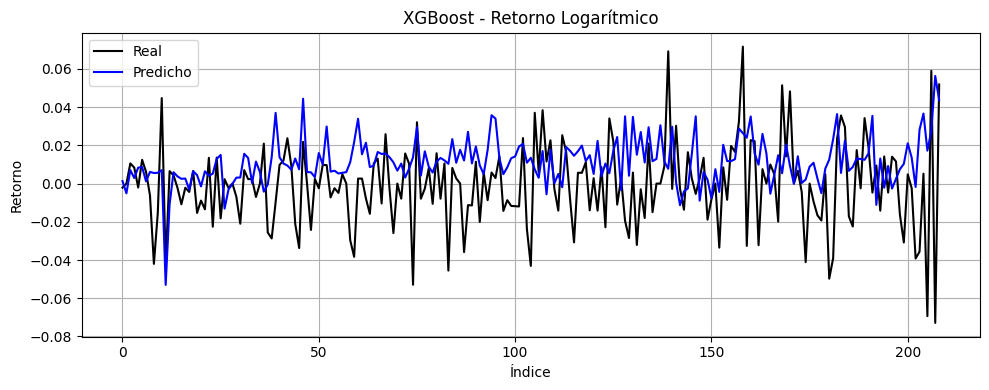

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test.values, label='Real', color='black')
plt.plot(range(len(preds)), preds, label='Predicho', color='blue')
plt.title("XGBoost - Retorno Logarítmico")
plt.xlabel("Índice")
plt.ylabel("Retorno")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Última secuencia conocida del set completo (escalada)
ultima_ventana = x_val_scaled[-sequence_length:]

# Reorganizarla al formato esperado (batch_size=1, sequence_length, features)
input_modelo = ultima_ventana.reshape((1, sequence_length, x_val_scaled.shape[1]))

# Elegir modelo (ejemplo: stacked_lstm, cnn_lstm, etc.)
pred_scaled = stacked_lstm.predict(input_modelo)

# Desescalar
pred_real = scaler_y.inverse_transform(pred_scaled)
print("Pronóstico del siguiente retorno logarítmico:", pred_real.flatten()[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Pronóstico del siguiente retorno logarítmico: -0.012671148
